## Лабораторная работа №2-3: Классификация
### Кредитный скоринг
**Данные:**
* ApplicationDate: Дата подачи заявки на кредит
* Age: Возраст заявителя
* AnnualIncome: Годовой доход
* CreditScore: Оценка кредитоспособности
* LoanAmount: Запрашиваемая сумма кредита
* LoanDuration: Срок погашения кредита
* MaritalStatus: Семейное положение заявителя
* NumberOfDependents: Количество иждивенцев
* HomeOwnershipStatus: Статус владения жильем
* MonthlyDebtPayments: Ежемесячные обязательства по долгам
* CreditCardUtilizationRate: Процент использования кредитной карты
* NumberOfOpenCreditLines: Активные кредитные линии
* NumberOfCreditInquiries: Количество запросов на кредит
* DebtToIncomeRatio: Соотношение долга к доходу
* BankruptcyHistory: История банкротств
* LoanPurpose: Цель кредита
* PreviousLoanDefaults: Предыдущие дефолты по кредитам
* PaymentHistory: История платежей
* LengthOfCreditHistory: Длительность кредитной истории
* SavingsAccountBalance: Баланс сберегательного счета
* CheckingAccountBalance: Баланс расчетного счета
* TotalAssets: Общая стоимость активов
* TotalLiabilities: Общая сумма обязательств
* MonthlyIncome: Ежемесячный доход
* UtilityBillsPaymentHistory: История платежей по коммунальным услугам
* JobTenure: Длительность работы на текущем месте
* EmploymentStatus: Статус занятости
* EducationLevel: Уровень образования
* Experience: Опыт работы
* NetWorth: Чистая стоимость активов
* BaseInterestRate: Базовая процентная ставка
* InterestRate: Применяемая процентная ставка
* MonthlyLoanPayment: Ежемесячный платеж по кредиту
* TotalDebtToIncomeRatio: Общее соотношение долга к доходу

**Цель: ROC-AUC > 0.75**

In [10]:
!pip install xgboost

# Решение

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    auc,
    classification_report,
    confusion_matrix,
    roc_curve
)

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV
)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

### 1. Загрузка и первичный анализ

In [12]:
train = pd.read_csv("data/train_c.csv")
test = pd.read_csv("data/test_c.csv")

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

TARGET = 'LoanApproved'

Train shape: (11017, 35)
Test shape: (5000, 35)


Распределение LoanApproved:
LoanApproved
1.0    5367
0.0    5120
Name: count, dtype: int64

Доля класса 1: 0.5118


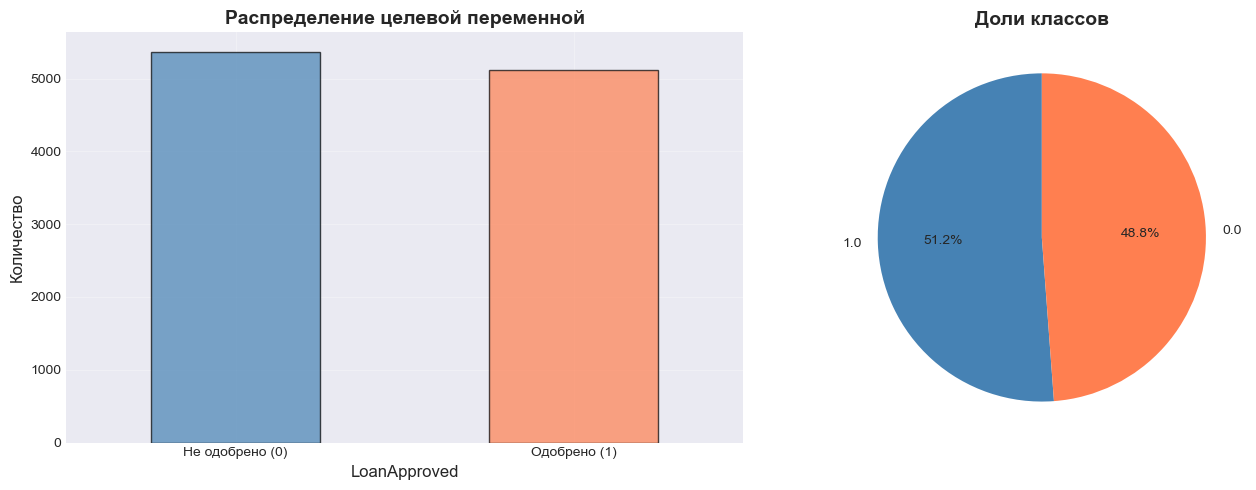

In [13]:
print(f"Распределение {TARGET}:")
print(train[TARGET].value_counts())
print(f"\nДоля класса 1: {train[TARGET].mean():.4f}")

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

train[TARGET].value_counts().plot(kind='bar', ax=ax[0], color=['steelblue', 'coral'],
edgecolor='black', alpha=0.7)
ax[0].set_xlabel(TARGET, fontsize=12)
ax[0].set_ylabel('Количество', fontsize=12)
ax[0].set_title('Распределение целевой переменной', fontsize=14, fontweight='bold')
ax[0].set_xticklabels(['Не одобрено (0)', 'Одобрено (1)'], rotation=0)
ax[0].grid(alpha=0.3)

colors = ['steelblue', 'coral']
train[TARGET].value_counts().plot(kind='pie', ax=ax[1], colors=colors,
autopct='%1.1f%%', startangle=90)
ax[1].set_ylabel('')
ax[1].set_title('Доли классов', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### 2. Предобработка данных (аналогично лр 1)

In [14]:
# удалим дубли
original_len = len(train)
train = train.drop_duplicates()
print(f"Удалено дубликатов: {original_len - len(train)}")

y_full = train[TARGET].copy()
train = train.drop(columns=[TARGET])

# добавляем метку источника данных
train['_source'] = 'train'
test['_source'] = 'test'

Удалено дубликатов: 1016


### 3. Преобразование категориальных признаков

In [15]:
# объединим для one-hot encoding
combined = pd.concat([train, test], axis=0, ignore_index=True)
print(f"Объединенный датасет: {combined.shape}")

# определяем кат признаки
categorical_cols = combined.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('_source')  # исключаем служебную колонку

print(f"Категориальных признаков: {len(categorical_cols)}")

# one-hot encoding
combined = pd.get_dummies(combined, columns=categorical_cols, drop_first=True)
print(f"После кодирования: {combined.shape}")

# разделяем обратно
train = combined[combined['_source'] == 'train'].drop(columns=['_source'])
test = combined[combined['_source'] == 'test'].drop(columns=['_source'])

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

print(f"\nПосле разделения:")
print(f"Train: {train.shape}")
print(f"Test: {test.shape}")
print(f"Совпадают ли колонки: {train.columns.equals(test.columns)}")

Объединенный датасет: (15001, 36)
Категориальных признаков: 6
После кодирования: (15001, 15045)

После разделения:
Train: (10001, 15044)
Test: (5000, 15044)
Совпадают ли колонки: True


### 4. Обработка пропусков и выбросов в фичах

In [16]:
numeric_cols = train.select_dtypes(include=[np.number]).columns

for col in numeric_cols:
    # clipping выбросов по квантилям
    low, high = train[col].quantile([0.01, 0.99])
    train[col] = train[col].clip(lower=low, upper=high)
    test[col] = test[col].clip(lower=low, upper=high)

    # заполнение пропусков медианой
    med = train[col].median()
    train[col] = train[col].fillna(med)
    test[col] = test[col].fillna(med)
    
print(f"Обработано {len(numeric_cols)} числовых признаков")

Обработано 29 числовых признаков


### 5. Создание признаков (как в лр 1)

In [17]:
TOP_N_FEATURES = 50        # кол-во признаков для отбора
POLY_DEGREE_2 = 25         # кол-во признаков для полиномов степени 2
POLY_DEGREE_3 = 15         # кол-во признаков для полиномов степени 3
POLY_DEGREE_4 = 5          # кол-во признаков для полиномов степени 4
INTERACTION_FEATURES = 12  # кол-во признаков для взаимодействий
TRANSFORM_FEATURES = 10    # кол-во признаков для трансформаций
TRANSFORM_INV = 5          # кол-во признаков для inverse-трансформации

train_with_target = train.copy()
train_with_target[TARGET] = y_full

# отбор топ-признаков по корреляции
corr = train_with_target.corr()[TARGET].abs().sort_values(ascending=False)
top_feats = corr.index[1:TOP_N_FEATURES+1].tolist()  # без таргета

print(f"Отобрано {len(top_feats)} признаков")
print(f"Корреляция: от {corr[top_feats[-1]]:.4f} до {corr[top_feats[0]]:.4f}")

# создаем df с отобранными признаками
df = train[top_feats].copy()
df_test = test[top_feats].copy()

print(f"Размер df: {df.shape}")
print(f"Размер df_test: {df_test.shape}")

Отобрано 50 признаков
Корреляция: от 0.0103 до 0.7547
Размер df: (10001, 50)
Размер df_test: (5000, 50)


In [18]:
# cоздаем полиномиальные признаки
print(f"\nСоздаём полиномиальные признаки:")
print(f"Степень 2: {POLY_DEGREE_2} признаков")
print(f"Степень 3: {POLY_DEGREE_3} признаков")
print(f"Степень 4: {POLY_DEGREE_4} признаков")

# степень 2 (для топ-25 признаков)
for f in top_feats[:POLY_DEGREE_2]:
    df[f'{f}_2'] = df[f] ** 2
    df_test[f'{f}_2'] = df_test[f] ** 2

# степень 3 (для топ-15 признаков)
for f in top_feats[:POLY_DEGREE_3]:
    df[f'{f}_3'] = df[f] ** 3
    df_test[f'{f}_3'] = df_test[f] ** 3

# степень 4 (для топ-5 признаков)
for f in top_feats[:POLY_DEGREE_4]:
    df[f'{f}_4'] = df[f] ** 4
    df_test[f'{f}_4'] = df_test[f] ** 4

print(f"Размер после полиномов: {df.shape}")


Создаём полиномиальные признаки:
Степень 2: 25 признаков
Степень 3: 15 признаков
Степень 4: 5 признаков
Размер после полиномов: (10001, 95)


In [19]:
# создаем признаки взаимодействия
comb_pairs = list(combinations(top_feats[:INTERACTION_FEATURES], 2))

for a, b in comb_pairs:
    df[f'{a}x{b}'] = df[a] * df[b]
    df_test[f'{a}x{b}'] = df_test[a] * df_test[b]

print(f"Создано признаков взаимодействия: {len(comb_pairs)}")
print(f"Размер df: {df.shape}")

Создано признаков взаимодействия: 66
Размер df: (10001, 161)


In [20]:
# создаем трансформированные признаки

# log и sqrt трансформации
for f in top_feats[:TRANSFORM_FEATURES]:
    df[f'{f}_log'] = np.log1p(np.abs(df[f]))
    df_test[f'{f}_log'] = np.log1p(np.abs(df_test[f]))
    df[f'{f}_sqrt'] = np.sqrt(np.abs(df[f]))
    df_test[f'{f}_sqrt'] = np.sqrt(np.abs(df_test[f]))

# inverse трансформации
for f in top_feats[:TRANSFORM_INV]:
    df[f'{f}_inv'] = 1 / (np.abs(df[f]) + 1)
    df_test[f'{f}_inv'] = 1 / (np.abs(df_test[f]) + 1)

print(f"Размер df после трансформаций: {df.shape}")

Размер df после трансформаций: (10001, 186)


In [21]:
# создаем специфичные для кредитного скоринга признаки

# 1) консистентность дохода
if all(col in df.columns for col in ['AnnualIncome', 'MonthlyIncome']):
    df['Income_consistency'] = df['AnnualIncome'] / (df['MonthlyIncome'] * 12 + 1)
    df_test['Income_consistency'] = df_test['AnnualIncome'] / (df_test['MonthlyIncome'] * 12 + 1)
    
# 2) кредитный скор на единицу возраста
if all(col in df.columns for col in ['CreditScore', 'Age']):
    df['Credit_per_age'] = df['CreditScore'] / (df['Age'] + 1)
    df_test['Credit_per_age'] = df_test['CreditScore'] / (df_test['Age'] + 1)
    
# 3) отношение суммы кредита к годовому доходу
if all(col in df.columns for col in ['LoanAmount', 'AnnualIncome']):
    df['Loan_to_annual_income'] = df['LoanAmount'] / (df['AnnualIncome'] + 1)
    df_test['Loan_to_annual_income'] = df_test['LoanAmount'] / (df_test['AnnualIncome'] + 1)
    
print(f"Финальный размер df: {df.shape}")

Финальный размер df: (10001, 189)


### 6. Очистка NaN'ов и бесконечностей

In [22]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df_test.replace([np.inf, -np.inf], np.nan, inplace=True)

df.fillna(0, inplace=True)
df_test.fillna(0, inplace=True)

print(f"Очистка завершена. Размер df: {df.shape}")

Очистка завершена. Размер df: (10001, 189)


### 7. Удаление мультиколлинеарных признаков

In [23]:
from sklearn.feature_selection import VarianceThreshold

# удаляем константные признаки
selector = VarianceThreshold(threshold=0.01)
df_var = selector.fit_transform(df)
cols_var = df.columns[selector.get_support()].tolist()

df = df[cols_var]
df_test = df_test[cols_var]

print(f"После удаления низковариативных: {df.shape}")

# быстрый метод для мультиколлинеарности (на случайной выборке)
if df.shape[1] > 100:
    # вычисляем корреляцию на выборке
    sample_size = min(5000, len(df))
    df_sample = df.sample(n=sample_size, random_state=42)
    
    corr_matrix = df_sample.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    THRESHOLD = 0.99  # было 0.995
    to_drop = [column for column in upper.columns if any(upper[column] > THRESHOLD)]
    
    df.drop(columns=to_drop, inplace=True)
    df_test.drop(columns=to_drop, inplace=True)
    
    print(f"Удалено мультиколлинеарных: {len(to_drop)}")

print(f"Финальное количество признаков: {df.shape[1]}")

После удаления низковариативных: (10001, 157)
Удалено мультиколлинеарных: 41
Финальное количество признаков: 116


### 8. Масштабирование признаков (как в лр 1)

In [24]:
# использую также RobustScaler

scaler = RobustScaler()
X_scaled = scaler.fit_transform(df)
X_test_scaled = scaler.transform(df_test)

print(f"Размер X_scaled: {X_scaled.shape}")
print(f"Размер X_test_scaled: {X_test_scaled.shape}")

Размер X_scaled: (10001, 116)
Размер X_test_scaled: (5000, 116)


### 9. Разделение на train/validation

In [27]:
print(f"Размер y_full: {len(y_full)}")
print(f"NaN в y_full: {y_full.isna().sum()}")

if y_full.isna().sum() > 0:
    nan_indices = y_full[y_full.isna()].index
    print(f"Удаляем строки с NaN в y_full: {len(nan_indices)} шт.")
    X_scaled = np.delete(X_scaled, nan_indices, axis=0)
    y_full = y_full.drop(nan_indices)
    print(f"Новый размер X_scaled: {X_scaled.shape}")
    print(f"Новый размер y_full: {len(y_full)}")

X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, 
    y_full, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_full
)

print(f"Train: {X_train.shape[0]} образцов")
print(f"Validation: {X_val.shape[0]} образцов")

print(f"\nРаспределение классов:")
print(f"Train: {y_train.value_counts().to_dict()}")
print(f"Val: {y_val.value_counts().to_dict()}")

Размер y_full: 10001
NaN в y_full: 1
Удаляем строки с NaN в y_full: 1 шт.
Новый размер X_scaled: (10000, 116)
Новый размер y_full: 10000
Train: 8000 образцов
Validation: 2000 образцов

Распределение классов:
Train: {1.0: 4101, 0.0: 3899}
Val: {1.0: 1025, 0.0: 975}


### 9. Обучение базовой модели (Logistic Regression)

In [28]:
# обучаем без оптимизации
base_model = LogisticRegression(max_iter=1000, random_state=42)
base_model.fit(X_train, y_train)

# предсказания
y_pred_proba = base_model.predict_proba(X_val)[:, 1]
y_pred = base_model.predict(X_val)

# метрики
roc_auc = roc_auc_score(y_val, y_pred_proba)

precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
pr_auc = auc(recall, precision)

print("Результаты базовой модели (Logistic Regression):")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC:  {pr_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

Результаты базовой модели (Logistic Regression):
ROC-AUC: 0.9828
PR-AUC:  0.9848

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93       975
         1.0       0.93      0.93      0.93      1025

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



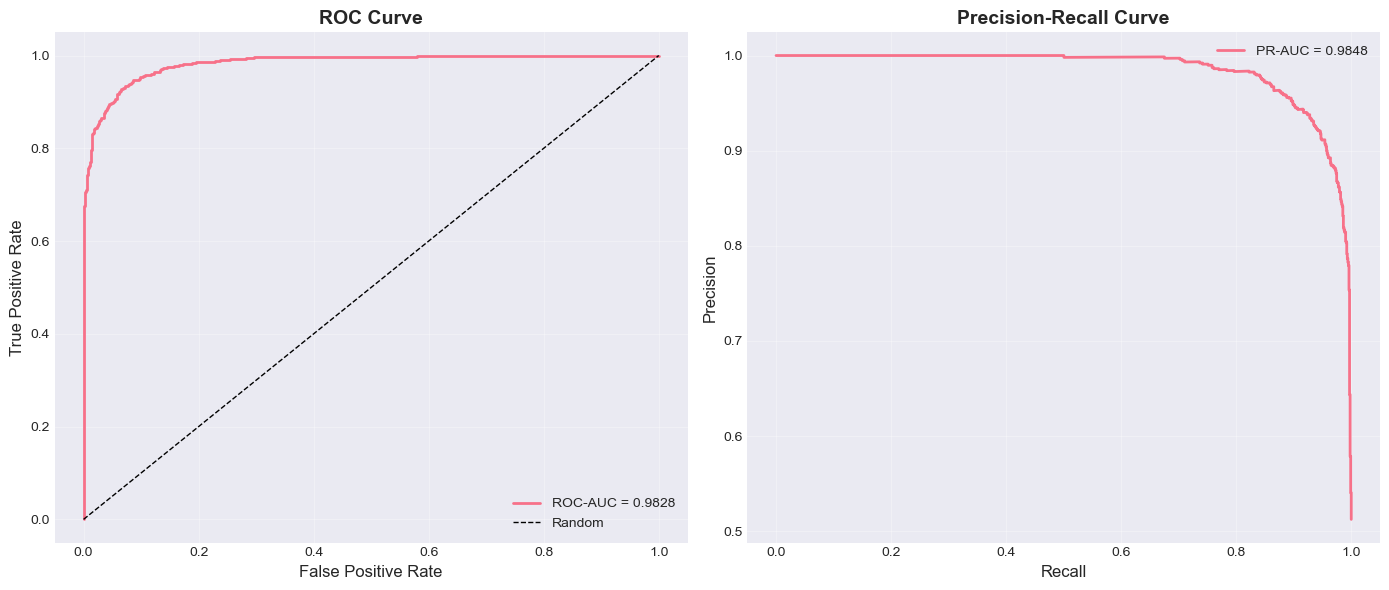

In [30]:
# визуализация roc и precision-recall кривых
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# roc curve
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
axes[0].plot(fpr, tpr, label=f'ROC-AUC = {roc_auc:.4f}', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# precision-recall curve
axes[1].plot(recall, precision, label=f'PR-AUC = {pr_auc:.4f}', linewidth=2)
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

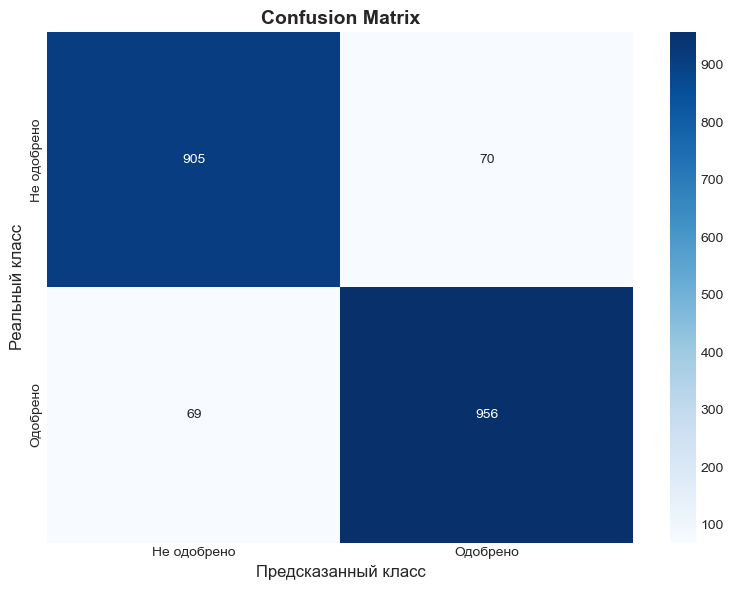

In [32]:
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
    xticklabels=['Не одобрено', 'Одобрено'],
    yticklabels=['Не одобрено', 'Одобрено'])
plt.xlabel('Предсказанный класс', fontsize=12)
plt.ylabel('Реальный класс', fontsize=12)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 10. Оптимизация гиперпараметров: GridSearchCV (Lab 3)

In [33]:
# сетка гиперпараметров для log reg
param_grid = {
'C': [0.001, 0.01, 0.1, 1, 10],
'penalty': ['l1', 'l2'],
'solver': ['liblinear'],  # поддерживает l1 и l2
'max_iter': [500, 1000]
}

grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

print(f"\nЛучшие параметры: {grid_search.best_params_}")
print(f"Лучший ROC-AUC (на кросс-валидации): {grid_search.best_score_:.4f}")

#лучщая модель
best_lr = grid_search.best_estimator_

# предсказания на валидации
y_pred_proba_lr = best_lr.predict_proba(X_val)[:, 1]
y_pred_lr = best_lr.predict(X_val)

#метрики
roc_auc_lr = roc_auc_score(y_val, y_pred_proba_lr)
precision_lr, recall_lr, _ = precision_recall_curve(y_val, y_pred_proba_lr)
pr_auc_lr = auc(recall_lr, precision_lr)

print(f"\nРезультаты оптимизированной Logistic Regression:")
print(f"ROC-AUC: {roc_auc_lr:.4f}")
print(f"PR-AUC:  {pr_auc_lr:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Лучшие параметры: {'C': 1, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
Лучший ROC-AUC (на кросс-валидации): 0.9853

Результаты оптимизированной Logistic Regression:
ROC-AUC: 0.9829
PR-AUC:  0.9850


### 11. RandomForest с RandomizedSearchCV

In [34]:
# сетка гиперпараметров для RandomForest
param_dist_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# RandomizedSearchCV (быстрее чем Grid для большой сетки
random_search_rf = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=20,  # кол-во комбинаций
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search_rf.fit(X_train, y_train)

print(f"\nЛучшие параметры: {random_search_rf.best_params_}")
print(f"Лучший ROC-AUC (на кросс-валидации): {random_search_rf.best_score_:.4f}")


# лучшая модель
best_rf = random_search_rf.best_estimator_

# предсказания
y_pred_proba_rf = best_rf.predict_proba(X_val)[:, 1]
y_pred_rf = best_rf.predict(X_val)

# метрики
roc_auc_rf = roc_auc_score(y_val, y_pred_proba_rf)
precision_rf, recall_rf, _ = precision_recall_curve(y_val, y_pred_proba_rf)
pr_auc_rf = auc(recall_rf, precision_rf)

print(f"\nРезультаты оптимизированной Random Forest:")
print(f"ROC-AUC: {roc_auc_rf:.4f}")
print(f"PR-AUC:  {pr_auc_rf:.4f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Лучшие параметры: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None}
Лучший ROC-AUC (на кросс-валидации): 0.9802

Результаты оптимизированной Random Forest:
ROC-AUC: 0.9785
PR-AUC:  0.9803


### 12. XGBoost с GridSearchCV

In [35]:
# сетка гиперпараметров для XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# GridSearchCV
grid_search_xgb = GridSearchCV(
    XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    param_grid_xgb,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search_xgb.fit(X_train, y_train)

print(f"\nЛучшие параметры: {grid_search_xgb.best_params_}")
print(f"Лучший ROC-AUC (на кросс-валидации): {grid_search_xgb.best_score_:.4f}")

# лучшая модель
best_xgb = grid_search_xgb.best_estimator_

# предсказания
y_pred_proba_xgb = best_xgb.predict_proba(X_val)[:, 1]
y_pred_xgb = best_xgb.predict(X_val)

# метрики
roc_auc_xgb = roc_auc_score(y_val, y_pred_proba_xgb)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_val, y_pred_proba_xgb)
pr_auc_xgb = auc(recall_xgb, precision_xgb)

print(f"\nРезультаты оптимизированной XGBoost:")
print(f"ROC-AUC: {roc_auc_xgb:.4f}")
print(f"PR-AUC:  {pr_auc_xgb:.4f}")

Fitting 3 folds for each of 72 candidates, totalling 216 fits

Лучшие параметры: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Лучший ROC-AUC (на кросс-валидации): 0.9837

Результаты оптимизированной XGBoost:
ROC-AUC: 0.9802
PR-AUC:  0.9824


### 13. Сравним модели

In [37]:
# сравнительная таблица
comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'ROC-AUC': [roc_auc_lr, roc_auc_rf, roc_auc_xgb],
    'PR-AUC': [pr_auc_lr, pr_auc_rf, pr_auc_xgb]
})

comparison = comparison.sort_values('ROC-AUC', ascending=False).reset_index(drop=True)
comparison.index = comparison.index + 1

print("Сравнение моделей:")
print(comparison.to_string())

Сравнение моделей:
                 Model   ROC-AUC    PR-AUC
1  Logistic Regression  0.982919  0.984974
2              XGBoost  0.980165  0.982438
3        Random Forest  0.978483  0.980309


### 14. Лучшая модель и финальное обучение

По ROC-AUC лучшей моделью оказалась **Logistic Regression**:

In [38]:
final_model = best_lr

final_model.fit(X_scaled, y_full)

test_proba = final_model.predict_proba(X_test_scaled)[:, 1]

submission = pd.DataFrame({
    'ID': range(len(test_proba)),
    'LoanApproved': test_proba
})

submission.to_csv('submission.csv', index=False)
print(f"\nТестовые предсказания сохранены в файл 'submission.csv'")
print(f"Размер файла: {submission.shape}")


Тестовые предсказания сохранены в файл 'submission.csv'
Размер файла: (5000, 2)
